### Variable Scatter Plotter
A python script to plot a scatter plot for sensitivity analysis of one variable, specifically made for urban area analysis.
#### How to Use
* Change the array of `RUN_IDS` to the id in `~/runs/` that you want to compare
* Change `INDEPENDENT_VAR` name to the independent (x-axis) variable that you want to compare. Please change this to match the set of `RUN_IDS` since I don't have a good way to know which variable you want to analyze.
* `rural_land_type` is similar to the previous point, I don't have a good way to extract and reverse the mapping of the rural land variable.
* `ANALYZE_VARS` is the array that you can change the content to select which variable from WRF output to plot
* Now you can run the thing. Be careful of the variable dimensions. You can take a look inside the code to see where you should handle those

In [23]:
from netCDF4 import Dataset
from glob import glob
import numpy as np

from wrf import getvar, ALL_TIMES, extract_times

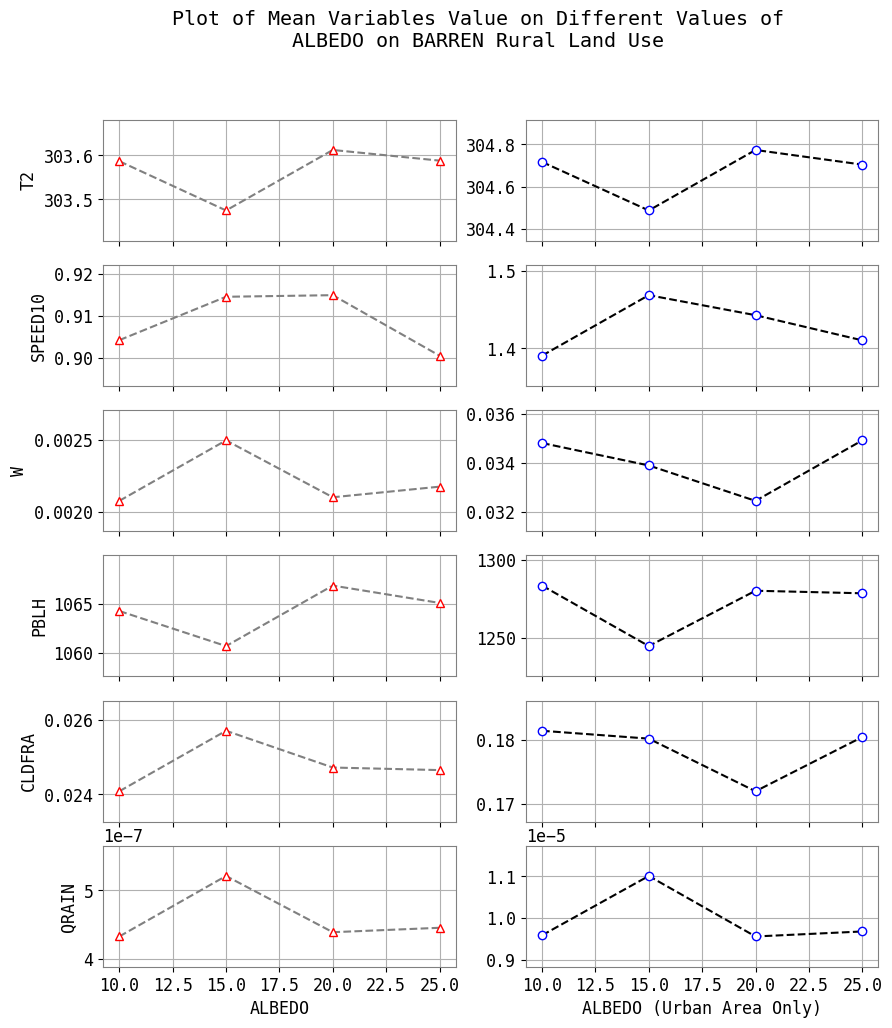

In [27]:
import matplotlib.pyplot as plt

RUN_IDS = [51, 79, 80, 81]
ALBEDO = [25, 20, 15, 10]

# BUILD_AREA_FRACTION   BUILDING PLAN AREA DENSITY 
# BUILD_SURF_RATIO      BUILDING SURFACE AREA TO PLAN AREA RATIO
# BUILD_HEIGHT          AVERAGE BUILDING HEIGHT WEIGHTED BY BUILDING PLAN AREA
# MH_URB2D              Mean Building Height
# STDH_URB2D            Standard Deviation of Building Height
# LF_URB2D              Frontal Area Index
# Z0_URB2D              Roughness length for momentum
# LF_URB2D_S            Frontal area index (use this one for analysis)
# AHE                   Anthropogenic heat emission
# URB_AREA_SIZE         Urban Area Size (custom)

INDEPENDENT_VAR = 'ALBEDO'
rural_land_type = 'barren'

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

threshold_datetime = np.datetime64('2025-03-10')

times = []

ANALYZE_VARS = ['T2', 'SPEED10', 'W', 'PBLH', 'CLDFRA', 'QRAIN']
fig, axes = plt.subplots(len(ANALYZE_VARS), 2, figsize=(10, 11), sharex=True)

for j, var_name in enumerate(ANALYZE_VARS):
    mean_var_values = []
    mean_var_values_urban = []
    for i, run_id in enumerate(RUN_IDS):
        # Not optimal, but we aren't working with that many datasets anyways
        file_name = glob(f'/home/guc/runs/{run_id:03}-*/wrfout*')[0]
        wrfinput_name = glob(f'/home/guc/runs/{run_id:03}-*/wrfinput*')[0]
        dataset = Dataset(file_name)
        wrfinput = Dataset(wrfinput_name)

        # Initialize times array for extraction
        if len(times) == 0:
            times = extract_times(dataset, timeidx=ALL_TIMES)

        # Get wind speed instead of just U10 V10
        if var_name == 'SPEED10':
            u10 = getvar(dataset, 'U10', timeidx=ALL_TIMES)
            v10 = getvar(dataset, 'V10', timeidx=ALL_TIMES)
            var_values = np.sqrt(u10**2 + v10**2)
        else: 
            var_values = getvar(dataset, var_name, timeidx=ALL_TIMES)

        # Cut variables value by threshold (spin-up time)
        cut_var_value = []
        for time_idx, date_time in enumerate(times):
            if (date_time < threshold_datetime): continue
            cut_var_value.append(var_values[time_idx])
        cut_var_value = np.array(cut_var_value)

        # Urban mask
        wrf_input_attrs = wrfinput.__dict__
        urban_mask = wrfinput.variables['LU_INDEX'][0] == wrf_input_attrs['ISURBAN']

        # Sample from the middle assuming it's urban
        # var_dimensions = wrfinput.variables[INDEPENDENT_VAR].ndim if INDEPENDENT_VAR != 'URB_AREA_SIZE' else 0
        # independent_var_value = (
        #     wrfinput.variables[INDEPENDENT_VAR][*(0 for _ in range(var_dimensions - 2)), 50, 50] if INDEPENDENT_VAR != 'URB_AREA_SIZE'
        #     else [20, 40, 30][i]
        # )
        independent_var_value = ALBEDO[i]
        mean_var_values.append((
            independent_var_value,
            np.mean(cut_var_value)
        ))
        mean_var_values_urban.append((
            independent_var_value,
            np.mean(cut_var_value[:, urban_mask]) if len(cut_var_value.shape) == 3
            else np.mean(cut_var_value[:, :, urban_mask])
        ))

    mean_var_values.sort()
    x_values = list(map(lambda x: x[0], mean_var_values))
    y_values = list(map(lambda x: x[1], mean_var_values))

    mean_var_values_urban.sort()
    x_values_urb = list(map(lambda x: x[0], mean_var_values_urban))
    y_values_urb = list(map(lambda x: x[1], mean_var_values_urban))

    axes[j][0].plot(x_values, y_values, '^--', mfc='white', mec='red', color='gray', label='All Area')
    axes[j][1].plot(x_values_urb, y_values_urb, 'o--', mfc='white', mec='blue', color='black', label='Urban Area')

    axes[j][0].margins(0.05, 0.5)
    axes[j][1].margins(0.05, 0.5)
    axes[j][0].grid()
    axes[j][1].grid()
    axes[j][0].set_ylabel(var_name)

for ax in axes:
    plt.setp(ax[0].spines.values(), color="gray")
    plt.setp(ax[1].spines.values(), color="gray")

axes[-1][0].set_xlabel(f'{INDEPENDENT_VAR} (%)')
axes[-1][1].set_xlabel(f'{INDEPENDENT_VAR} (%) (Urban Area Only)')
fig.suptitle(f'Plot of Mean Variables Value on Different Values of\n{INDEPENDENT_VAR} on {rural_land_type.upper()} Rural Land Use')

plt.savefig(f'/home/guc/results/var-comparison/{rural_land_type}-{INDEPENDENT_VAR}.png')